SUMMARY
---

In this mini-project we have a problem of single label, multiclass classification. The dataset we are using is 'Reuters dataset', which is already included in the Keras package. Reuters dataset is a set of short newswires and their topics, published by Reuters in 1986. Each newswire belongs to one of the 46 different topic. 
It's a multiclass problem, because there are 46 different topics, yet single label since each data point has one-to-one corespodence with one of the 46 topics. 

This problem is 'almost the same' with the binary classification one, and the differences are as follows:

* What sigmoid is for binary classification, soft-max is for multiclass classification
* Since the dimension of output space is 46 we should 'not' include information bottleneck. That is, previous layers have less dimensions (aka units) than the (final) output layer/s, and hence compressing too much information which could help to make separation hyperplanes of 46 classes is a bad juju!

In [1]:
#Importing the dataset from Keras dataset library
from keras.datasets import reuters

#Importing libraries for data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Importing libraries for everything that deals with modeling
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.losses import categorical_crossentropy
from keras.metrics import accuracy

#For making ticks integer values
from matplotlib.ticker import MaxNLocator

Using TensorFlow backend.


### Importing training and test part of the set

Again, we are gonna stick to first 10000 most frequently used words to make learning feasible. 

In [2]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words = 10000)

In [3]:
#Checks to see if we imported data properly

train_data.shape, test_data.shape, train_labels.shape, test_labels.shape

((8982,), (2246,), (8982,), (2246,))

There are 8982 newswires in training, and 2246 in the test set. Close to 80%/20% split. Now we will see one of the decoded newswires and explore all the unique topics that those newswires are associated.

## Decoding first newswire

In [4]:
word_index = reuters.get_word_index() # {'word':'frequency_of_word'}
reverse_word_index = dict([(value, key)
                             for (key, value) in word_index.items()]) # {'frequency_of_word':'word'}

#Let's decode the first newswire in our training dataset
decoded_review_1 = ' '.join([reverse_word_index.get(i-3, '?')
                              for i in train_data[0]])
decoded_review_1

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

## Decoding topics

In [5]:
type(train_labels), np.unique(train_labels)

(numpy.ndarray,
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]))

A naive approach forgeting that most frequent words are for the newswires, not for unique labels.

In [6]:
list_of_topics = []
for idx in np.unique(train_labels):
    list_of_topics.append(reverse_word_index.get(idx))
    
#list_of_topics

Here are the orginal ones scraped from the web: 
  

In [7]:
reuters_topics = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
                  'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
                  'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
                  'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
                  'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

Reference: https://github.com/SteffenBauer/KerasTools/blob/master/KerasTools/datasets/decode.py

## Data preprocessing

As we learned in the IMDB example input data, as well as labels that we feed the network with must be vectorized, and by default we will use one-hot-encoding. But this time for the labels we could either choose to use one-hot-encoding IF we are using categorical_cross_entropy as our loss function to minimize, or we could leave them as numpy arrays but in that case we use sparse_categorical_cross_entropy. 
There is no difference between using each one of them, both loss functions are treating labels the same but one expects OHE, other one is 'okay' with the integer labels. 

PS I saw that this concept of converting integers to one-hot-encoding is actually 'bag of words' kinda thing. 

"If there is a word in this sequence of 10000 most frequent words on that index included write 1, else 0."

In [8]:
#Preprocessing training and test data

In [9]:
def vectorize_sequences(sequences, dimensions = 10000):
    results = np.zeros((len(sequences), dimensions))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [10]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [11]:
#Preprocessing training and test labels

In [12]:
def vectorize_labels(labels, dimensions = 46):
    results = np.zeros((len(labels), dimensions))
    for i, label in enumerate(labels):
        results[i,label] = 1.
    return results

In [13]:
y_train = vectorize_labels(train_labels)
y_test = vectorize_labels(test_labels)

## The model definition

As we explained in the summary part we are gonna use the architeture such that layers up to the last one have hidden units that are bigger or equal then the last one. I forgot to explain the softmax activation, which is used as an output when we have multiclass problems. One can think of softmax as 'probability distribution' since for each number in vector [a, b, c ... d] it returns it's probability [p(a), p(b), p(c), ... p(d)]. Seen that vector as encoding each probability of each term of a vector we can think of it as a distribution of probabilities. 

I think the way I presented the model here might be cumbersome, so in the next project I will import libraries to make my code more meaningful.

In [14]:
model = Sequential()
model.add(Dense(64, activation = 'relu', input_shape = (10000,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(46, activation = 'softmax'))

### Defining custom loss and metric

In [15]:
model.compile(optimizer = RMSprop(lr = 0.01),
             loss = categorical_crossentropy,
             metrics = ['accuracy'])

## Spliting the training data into training and validation data

We will set apart 1000 samples in the training data as our validation set

In [16]:
#Validation set
x_val = x_train[:1000]

#Partial training set
partial_x_train = x_train[1000:]

and the rest of the samples are those that we are gonna train on. 

In [17]:
#Validation labels
y_val = y_train[:1000]

#Partial training set labels
partial_y_train = y_train[1000:]

## Training the Neural Network

We will train the networks again, with the 20 epochs with the size of batch that is 2^n where n is natural number. We can train our network to how many epochs we want, but I think that comes down to 'I saw some wierdness, let's train it longer' or so. We have less data so the training should be 'quick'.

In [18]:
history = model.fit(partial_x_train,
                  partial_y_train,
                  epochs = 20,
                  batch_size = 512,
                  validation_data = (x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 151us/step - loss: 1.8925 - accuracy: 0.5665 - val_loss: 1.2652 - val_accuracy: 0.6920
Epoch 2/20
7982/7982 [==============================] - 1s 66us/step - loss: 0.9195 - accuracy: 0.7749 - val_loss: 0.9491 - val_accuracy: 0.7880
Epoch 3/20
7982/7982 [==============================] - 1s 67us/step - loss: 0.5293 - accuracy: 0.8624 - val_loss: 1.1379 - val_accuracy: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 76us/step - loss: 0.3055 - accuracy: 0.9217 - val_loss: 0.9614 - val_accuracy: 0.7950
Epoch 5/20
7982/7982 [==============================] - 1s 81us/step - loss: 0.2409 - accuracy: 0.9381 - val_loss: 0.9773 - val_accuracy: 0.8130
Epoch 6/20
7982/7982 [==============================] - 1s 77us/step - loss: 0.1788 - accuracy: 0.9471 - val_loss: 0.9568 - val_accuracy: 0.8030
Epoch 7/20
7982/7982 [==============================] - 1s 65us/step - loss: 0.15

## Ploting training and test data loss

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

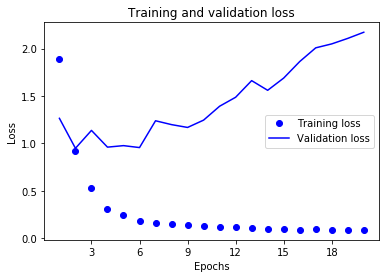

In [20]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss'] 

epochs = range(1, len(loss_values) + 1)

#Making ticks integer valued
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(epochs, loss_values, 'bo', label = "Training loss")
plt.plot(epochs, val_loss_values, 'b', label = "Validation loss")

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Ploting training and validation accuracy

<Figure size 432x288 with 0 Axes>

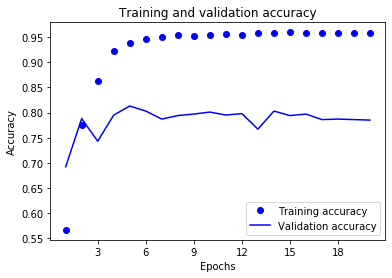

In [21]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

#Making ticks integer valued
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Re-training

We can observe from our training loss that network starts to overfit after 6 epochs, and that our accuracy actually peaks on validation at the same epoch. We gonna retrain our network to same number of epochs.

In [24]:
model_1 = Sequential()
model_1.add(Dense(64, activation = 'relu', input_shape = (10000,)))
model_1.add(Dense(64, activation = 'relu'))
model_1.add(Dense(46, activation = 'softmax'))

model_1.compile(optimizer = RMSprop(lr = 0.01),
             loss = categorical_crossentropy,
             metrics = ['accuracy'])

history = model_1.fit(x_train,
                  y_train,
                  epochs = 6,
                  batch_size = 512)

Epoch 1/6
8982/8982 [==============================] - 1s 95us/step - loss: 1.8740 - accuracy: 0.5628
Epoch 2/6
8982/8982 [==============================] - 1s 57us/step - loss: 0.8934 - accuracy: 0.7791
Epoch 3/6
8982/8982 [==============================] - 1s 58us/step - loss: 0.4981 - accuracy: 0.8717
Epoch 4/6
8982/8982 [==============================] - 1s 70us/step - loss: 0.3650 - accuracy: 0.9046
Epoch 5/6
8982/8982 [==============================] - 1s 57us/step - loss: 0.2195 - accuracy: 0.9410
Epoch 6/6
8982/8982 [==============================] - 1s 57us/step - loss: 0.1897 - accuracy: 0.9463


## Evaluation and predictions

In [27]:
results = model_1.evaluate(x_test, y_test)
results

2246/2246 [==============================] - 0s 72us/step


[1.4867121602208722, 0.7564558982849121]

In [37]:
#Predictions
predictions = model.predict(x_test)
predictions[0].shape, np.argmax(predictions[0])

((46,), 17)